<a href="https://colab.research.google.com/github/haytham918/low-rank-expectile/blob/main/LRE_wt_BFGS_ActualData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from scipy.stats import norm
from scipy.optimize import minimize

Mounted at /content/drive
Matrix shape is : (288, 334)
Number of Missing values:  28674
Proportion of Missing values:  29.809131736526943 %
Index of the interval where there is no data at all:  (array([], dtype=int64),)


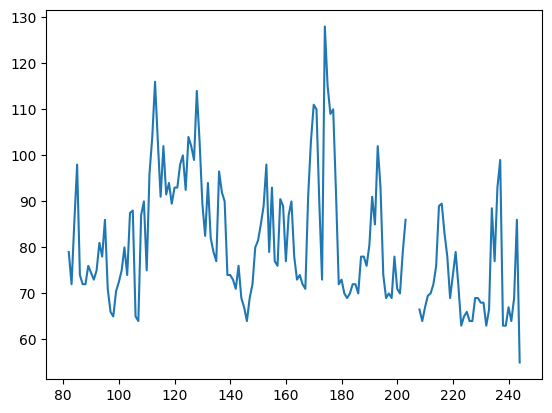

In [2]:
from google.colab import drive
drive.mount('/content/drive')
processed_df = pd.read_csv("/content/drive/MyDrive/low-rank-expectile/processed_heartrate.csv")
# Convert the df to numpy matrix
user_times_matrix = processed_df.values
# Nan Mask Matrix for the matrix
nan_mask = np.isnan(user_times_matrix)

number_missing = np.sum(nan_mask)
matrix_shape = user_times_matrix.shape
print("Matrix shape is :", matrix_shape)
print("Number of Missing values: ", number_missing)
print("Proportion of Missing values: ", number_missing / (matrix_shape[0] * matrix_shape[1]) * 100, "%")

# Check if there is any interval that there is no data from any user
print("Index of the interval where there is no data at all: ", np.where(nan_mask.sum(axis=1) == matrix_shape[1]))
# Get the masked matrix so that we ignore nan values
masked_matrix = np.ma.array(user_times_matrix, mask=nan_mask)
# print(np.mean(masked_matrix, axis=1)[287])
interval_array = np.arange(0, 288)
plt.plot(interval_array, user_times_matrix[:,22])

In [3]:
def get_observed_mask(X):
    return ~np.isnan(X)

def compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau):
    m, n = X.shape
    k = U.shape[1]

    # Construct approximation and error matrices
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    # Get weight
    W = np.where(error_matrix >= 0, tau, 1 - tau)

    # Calculate gradient
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    return R_grad, C_grad, U_grad, V_grad

def expectile_loss_vectorized(X, R, C, U, V, M, tau):
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()

    return loss

def expectile_gradient_descent_vectorized(X, k, epochs, eta, tau):
    m, n = X.shape
    R = np.zeros(m)
    C = np.zeros(n)
    U = np.random.normal(0, 0.1, (m, k))
    V = np.random.normal(0, 0.1, (n, k))
    M = get_observed_mask(X)

    for epoch in range(epochs):
        R_grad, C_grad, U_grad, V_grad = compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau)
        R -= eta * R_grad
        C -= eta * C_grad
        U -= eta * U_grad
        V -= eta * V_grad

        if epoch % 10 == 9:
            current_loss = expectile_loss_vectorized(X, R, C, U, V, M, tau)
            print(f"Epoch {epoch+1}: Loss = {current_loss}")

    return R, C, U, V

In [29]:
def flatten_parameters(R, C, U, V):
    return np.concatenate([R, C, U.flatten(), V.flatten()])

def unflatten_parameters(params, m, n, k):
    R = params[:m]
    C = params[m:m+n]
    U = params[m+n:m+n+m*k].reshape(m, k)
    V = params[m+n+m*k:].reshape(n, k)
    return R, C, U, V

def total_loss_and_gradient(params, X, M, tau, m, n, k, loss_array):
    R, C, U, V = unflatten_parameters(params, m, n, k)
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()
    loss_array.append(loss)

    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    grad = flatten_parameters(R_grad, C_grad, U_grad, V_grad)
    return loss, grad


def optimize_with_bfgs(X, k, tau, loss_array):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(0, 1, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='BFGS', jac=True, options={'disp': True, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    print(f"Array Length: {len(loss_array)}")
    return R, C, U, V

def optimize_with_lbfgs(X, k, tau, loss_array):
    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(0, 1, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='L-BFGS-B', jac=True, options={'disp': True, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    print(f"Array Length: {len(loss_array)}")
    return R, C, U, V

def optimize_with_bfgs_sep_init(X, k, tau, row_mean, col_mean, loss_array):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_r_param = row_mean
    initial_c_param = col_mean
    initial_uv_param = np.random.normal(0, 1, m*k + n*k)
    initial_params = np.concatenate((initial_r_param, initial_c_param, initial_uv_param))

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='BFGS', jac=True, options={'disp': True, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    print(f"Array Length: {len(loss_array)}")
    return R, C, U, V

def optimize_with_lbfgs_sep_init(X, k, tau, row_mean, col_mean, loss_array):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_r_param = row_mean
    initial_c_param = col_mean
    initial_uv_param = np.random.normal(0, 1, m*k + n*k)
    initial_params = np.concatenate((initial_r_param, initial_c_param, initial_uv_param))

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method='L-BFGS-B', jac=True, options={'disp': True, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"Final Loss: {final_loss}")
    print(f"Array Length: {len(loss_array)}")
    return R, C, U, V


In [30]:
mean_nona = np.mean(masked_matrix)
std_val = np.std(masked_matrix)
X_normalized = user_times_matrix - mean_nona
X_normalized /= std_val
print("MEAN", mean_nona)
print("STD: ", std_val)
# print("Row Mean: ", row_mean)
# print("Col Mean: ", col_mean)
print(X_normalized)
X_new = np.ma.array(X_normalized, mask=np.isnan(X_normalized))
row_mean = np.mean(X_new, 1)
col_mean = np.mean(X_new, 0)
print("NEW MEAN: ", np.mean(X_new))
print("NEW STD: ", np.std(X_new))


MEAN 73.7046491306022
STD:  16.320639272086176
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
NEW MEAN:  2.1173790461052187e-16
NEW STD:  1.0


Final Loss: 0.21517560179415762
Array Length: 76
[[ 49.71724419  57.9196632   63.73865111 ...  65.24518701 130.26300943
  119.22877268]
 [ 46.45850975  53.18748193  63.84503557 ...  66.53651199 141.0343144
  127.91123675]
 [ 49.61601994  56.75843518  64.04575869 ...  66.0411899  132.25245549
  120.82535155]
 ...
 [ 56.66189057  58.96520179  63.33800114 ...  65.82793484 110.59912266
  102.68237152]
 [ 56.39585024  58.52255689  63.52630069 ...  66.16747256 112.21750246
  104.0222603 ]
 [ 57.11069085  61.96045969  63.71276171 ...  65.19204379 109.6316364
  102.15854891]]


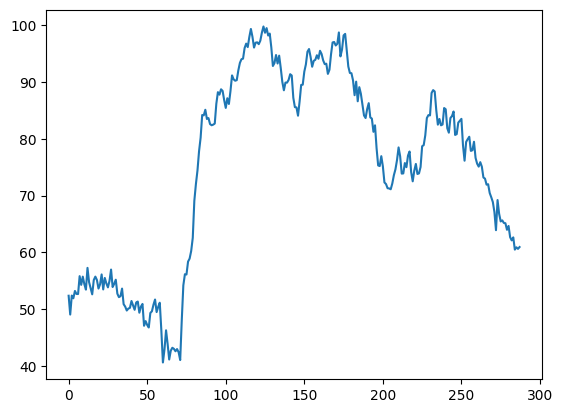

In [31]:
# LBBFGS, STANDAD NORMAL
lbfgs_normal_loss_array = []
tau = 0.8
R_l, C_l, U_l, V_l = optimize_with_lbfgs(X_normalized, 2, tau, lbfgs_normal_loss_array)
X_hat_l = R_l[:,np.newaxis]*std_val + C_l*std_val + U_l*std_val @ V_l.T + mean_nona
print(X_hat_l)
plt.plot(interval_array, X_hat_l[:,22])

Final Loss: 0.21526875003696483
Array Length: 94
[[ 52.24236379  59.56386121  63.85198466 ...  65.10129075 122.60477544
  112.8432996 ]
 [ 48.22984808  54.32023835  63.88985164 ...  66.19410782 134.69961998
  122.53010511]
 [ 52.08564817  58.0146317   64.21670847 ...  66.0067829  124.88067334
  114.60426748]
 ...
 [ 56.92827836  59.463762    63.69650672 ...  65.73830921 109.85801084
  101.9357117 ]
 [ 56.57714859  59.052152    63.89949989 ...  66.05020455 111.67908836
  103.44527667]
 [ 57.49369121  62.32784218  63.98908124 ...  65.23270653 108.6938522
  101.30170906]]


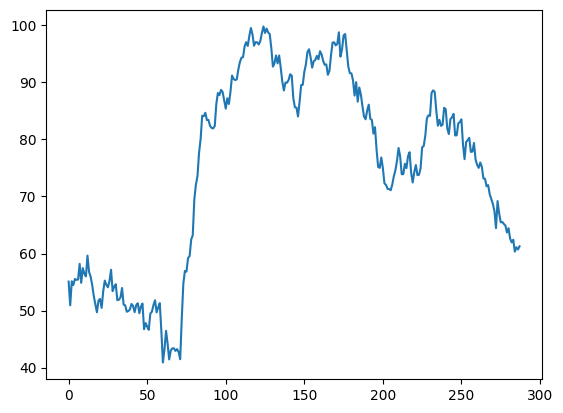

In [32]:
# LBBFGS, Use ROW/COL Mean
lbfgs_mean_loss_array = []
tau = 0.8
R_l_s, C_l_s, U_l_s, V_l_s = optimize_with_lbfgs_sep_init(X_normalized, 2, tau, row_mean, col_mean, lbfgs_mean_loss_array)
X_hat_l_s = R_l_s[:,np.newaxis]*std_val + C_l_s*std_val + U_l_s*std_val @ V_l_s.T + mean_nona
print(X_hat_l_s)
plt.plot(interval_array, X_hat_l_s[:,22])

         Current function value: 0.215438
         Iterations: 500
         Function evaluations: 506
         Gradient evaluations: 506
Final Loss: 0.21543774504645313
Array Length: 506
[[ 70.24898319 105.99722066  68.2136198  ...  62.62101505  63.8538495
   58.04961305]
 [ 71.73255822 110.53594571  69.17684112 ...  63.10704022  60.65395067
   56.32197125]
 [ 71.87258347 107.31273014  68.98124127 ...  63.41983489  62.24884357
   57.76635693]
 ...
 [ 72.97040826  96.33431382  67.31353422 ...  63.54852869  62.21368842
   59.71612165]
 [ 73.43242648  95.01290241  67.49611707 ...  63.99880833  63.03383556
   60.62066436]
 [ 69.39816793  89.58554763  66.59035026 ...  63.36449535  72.91355944
   65.14998926]]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


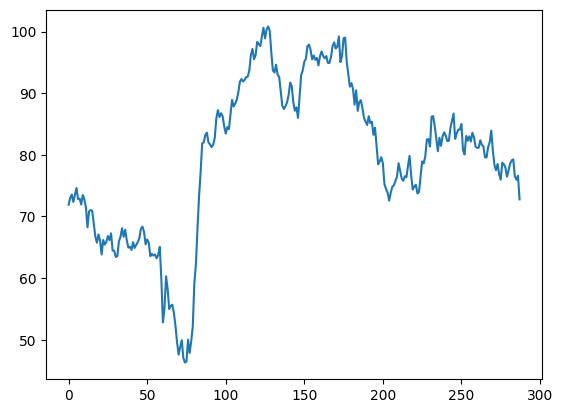

In [33]:
# BFGS, standard normal
bfgs_normal_loss_array = []
tau = 0.8
R, C, U, V = optimize_with_bfgs(X_normalized, 2, tau, bfgs_normal_loss_array)
X_hat = R[:,np.newaxis]*std_val + C*std_val + U*std_val @ V.T + mean_nona
print(X_hat)
plt.plot(interval_array, X_hat[:,22])

         Current function value: 0.215676
         Iterations: 500
         Function evaluations: 505
         Gradient evaluations: 505
Final Loss: 0.2156755004730421
Array Length: 505
[[ 52.35173491  59.474547    63.6737555  ...  65.44273813 125.88340103
  117.48618362]
 [ 48.65275223  55.09775516  63.74590818 ...  66.4929697  138.91653517
  128.41857249]
 [ 52.45819716  58.67844454  64.0421025  ...  66.1730635  128.17629556
  119.36764351]
 ...
 [ 56.39301414  61.73903312  63.59980523 ...  65.16643492 114.67937106
  107.79346282]
 [ 56.89322549  61.20218708  63.75747733 ...  65.61289247 114.97540544
  107.93929398]
 [ 57.3150872   64.33527236  63.9849316  ...  64.87001654 111.32978217
  105.23269692]]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


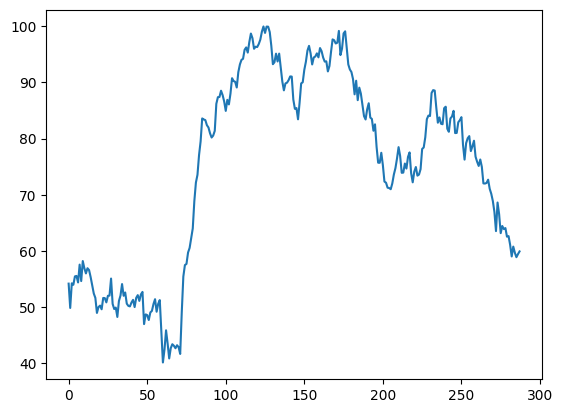

In [36]:
# BFGS, Use Row/Col Mean
bfgs_mean_loss_array = []
tau = 0.8
R_s, C_s, U_s, V_s = optimize_with_bfgs_sep_init(X_normalized, 2, tau, row_mean, col_mean, bfgs_mean_loss_array)
X_hat_s = R_s[:,np.newaxis]*std_val + C_s*std_val + U_s*std_val @ V_s.T + mean_nona
print(X_hat_s)
plt.plot(interval_array, X_hat_s[:,22])